# Importing Libraries for Hand Gesture Recognition and ML Model Training

In [1]:
# Data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and splitting
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# Machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model persistence
import joblib

# MediaPipe and OpenCV for hand tracking and real-time video
import mediapipe as mp
import cv2

# For smoothing predictions
from collections import deque

from sklearn.decomposition import PCA

In [56]:
#load the dataset
df  = pd.read_csv("hand_landmarks_data.csv")
df 

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25670,259.135620,277.542236,4.323656e-07,271.098221,257.333374,0.007132,269.350250,237.538345,0.004480,257.334503,...,231.102150,230.308350,-0.028861,235.017242,235.029312,-0.016911,237.608711,240.918411,-0.006697,two_up_inverted
25671,90.063995,256.181732,3.808555e-07,77.302231,237.829132,0.003778,78.658888,220.471680,-0.001519,89.374163,...,116.692326,210.932007,-0.043690,112.681984,215.274353,-0.029510,110.178349,221.338379,-0.015630,two_up_inverted
25672,236.724518,251.496756,5.912488e-07,254.918358,232.369956,0.001354,256.002502,209.969106,-0.001674,247.075447,...,211.933777,202.389975,-0.031740,215.493393,208.953272,-0.021970,218.057648,215.236920,-0.010803,two_up_inverted
25673,119.466957,309.842529,4.319564e-07,111.772064,291.310333,0.006174,116.895447,273.683929,0.001893,129.239788,...,157.217422,271.056702,-0.046297,154.780106,277.261139,-0.032800,150.117119,282.011047,-0.020277,two_up_inverted


# Check if normalization is needed

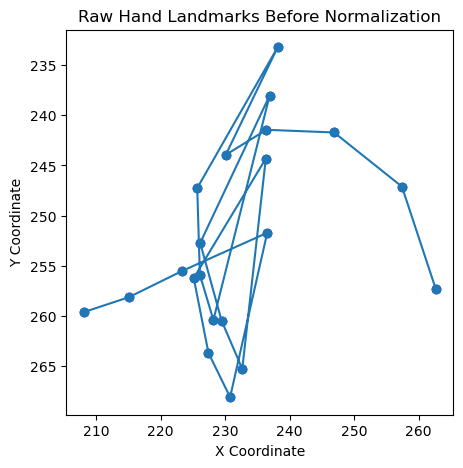

In [3]:
# Select a single sample (randomly or first row)
sample = df.iloc[0, :-1].values  # Exclude label column

# Extract x and y coordinates
x_coords = sample[0::3]  # extract all Xs
y_coords = sample[1::3]  # extract all Ys

# Plot hand landmarks
plt.figure(figsize=(5, 5))
plt.scatter(x_coords, y_coords, color="blue")
plt.plot(x_coords, y_coords, linestyle='-', marker='o')  # Connect keypoints

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Raw Hand Landmarks Before Normalization")
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinate system
plt.show()

The landmarks are spread across a wide range of X and Y coordinates instead of being aligned around a reference point (such as the wrist).
Normalization Will Fix the issues, also scaling is needed as there may be different hand sizes

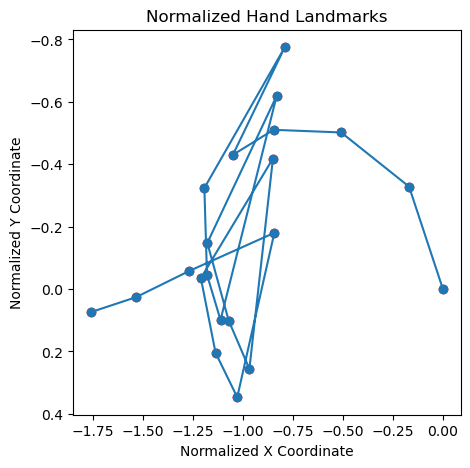

In [4]:
def normalize_landmarks(sample):
    # Extract x and y coordinates
    x_coords = np.array(sample[0::3])
    y_coords = np.array(sample[1::3])

    # Use wrist (landmark 0) as reference point
    wrist_x, wrist_y = x_coords[0], y_coords[0]

    # Recenter the hand
    x_coords -= wrist_x
    y_coords -= wrist_y

    # Scale using the mid-finger tip (landmark 12 or 8)
    scale_factor = np.linalg.norm([x_coords[12], y_coords[12]])  # Distance to mid-finger tip

    # Avoid division by zero
    if scale_factor > 0:
        x_coords /= scale_factor
        y_coords /= scale_factor

    return x_coords, y_coords

# Normalize and visualize
x_norm, y_norm = normalize_landmarks(sample)

plt.figure(figsize=(5, 5))
plt.scatter(x_norm, y_norm, color="red")
plt.plot(x_norm, y_norm, linestyle='-', marker='o')

plt.xlabel("Normalized X Coordinate")
plt.ylabel("Normalized Y Coordinate")
plt.title("Normalized Hand Landmarks")
plt.gca().invert_yaxis()
plt.show()

# Data Cleaning and preprocessing 

For a gesture recognition model using normal cameras, we just need (X, Y) so drop Z.

In [57]:
# Drop all columns with 'z' in their names
df_2D = df.drop(columns=[col for col in df.columns if 'z' in col])

In [39]:
df_2D.isna().sum()

x1       0
y1       0
x2       0
y2       0
x3       0
y3       0
x4       0
y4       0
x5       0
y5       0
x6       0
y6       0
x7       0
y7       0
x8       0
y8       0
x9       0
y9       0
x10      0
y10      0
x11      0
y11      0
x12      0
y12      0
x13      0
y13      0
x14      0
y14      0
x15      0
y15      0
x16      0
y16      0
x17      0
y17      0
x18      0
y18      0
x19      0
y19      0
x20      0
y20      0
x21      0
y21      0
label    0
dtype: int64

In [58]:
# Find rows with more than one null value
rows_with_nulls = df_2D[df_2D.isnull().sum(axis=1) > 1]

rows_with_nulls

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,...,y17,x18,y18,x19,y19,x20,y20,x21,y21,label


In [8]:
df_2D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 43 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      25675 non-null  float64
 1   y1      25675 non-null  float64
 2   x2      25675 non-null  float64
 3   y2      25675 non-null  float64
 4   x3      25675 non-null  float64
 5   y3      25675 non-null  float64
 6   x4      25675 non-null  float64
 7   y4      25675 non-null  float64
 8   x5      25675 non-null  float64
 9   y5      25675 non-null  float64
 10  x6      25675 non-null  float64
 11  y6      25675 non-null  float64
 12  x7      25675 non-null  float64
 13  y7      25675 non-null  float64
 14  x8      25675 non-null  float64
 15  y8      25675 non-null  float64
 16  x9      25675 non-null  float64
 17  y9      25675 non-null  float64
 18  x10     25675 non-null  float64
 19  y10     25675 non-null  float64
 20  x11     25675 non-null  float64
 21  y11     25675 non-null  float64
 22

In [59]:
#convert label column into string type
df_2D["label"] = df_2D["label"].astype("string")

In [20]:
df_2D.dtypes

x1              float64
y1              float64
x2              float64
y2              float64
x3              float64
y3              float64
x4              float64
y4              float64
x5              float64
y5              float64
x6              float64
y6              float64
x7              float64
y7              float64
x8              float64
y8              float64
x9              float64
y9              float64
x10             float64
y10             float64
x11             float64
y11             float64
x12             float64
y12             float64
x13             float64
y13             float64
x14             float64
y14             float64
x15             float64
y15             float64
x16             float64
y16             float64
x17             float64
y17             float64
x18             float64
y18             float64
x19             float64
y19             float64
x20             float64
y20             float64
x21             float64
y21             

In [38]:
#make sure label column only has 18 classes
df_2D["label"].nunique()

18

In [22]:
df_2D["label"].value_counts()

label
three2             1653
palm               1649
four               1634
ok                 1592
stop_inverted      1567
call               1506
peace_inverted     1497
stop               1482
rock               1458
three              1456
peace              1441
like               1436
two_up_inverted    1371
two_up             1343
dislike            1295
one                1263
mute               1087
fist                945
Name: count, dtype: Int64

In [60]:
# Define the gesture renaming map
gesture_map = {
    'like': 'up',
    'dislike': 'down',
    'fist': 'left',
    'call': 'right'
}

# Apply the renaming directly on df_2D
df_2D.iloc[:, -1] = df_2D.iloc[:, -1].apply(lambda x: gesture_map.get(x, x))  # Rename only those 4




In [61]:
# Encode labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_2D.iloc[:, -1] = label_encoder.fit_transform(df_2D.iloc[:, -1])  # Convert gesture names to integers

# Save the mapping for later use
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'down': 0, 'four': 1, 'left': 2, 'mute': 3, 'ok': 4, 'one': 5, 'palm': 6, 'peace': 7, 'peace_inverted': 8, 'right': 9, 'rock': 10, 'stop': 11, 'stop_inverted': 12, 'three': 13, 'three2': 14, 'two_up': 15, 'two_up_inverted': 16, 'up': 17}


C:\Users\ayman\AppData\Local\Temp\ipykernel_20956\2261079732.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 9  9  9 ... 16 16 16]' has dtype incompatible with string, please explicitly cast to a compatible dtype first.
  df_2D.iloc[:, -1] = label_encoder.fit_transform(df_2D.iloc[:, -1])  # Convert gesture names to integers


In [40]:
df_2D["label"].value_counts()

label
14    1653
6     1649
1     1634
4     1592
12    1567
9     1506
8     1497
11    1482
10    1458
13    1456
7     1441
17    1436
16    1371
15    1343
0     1295
5     1263
3     1087
2      945
Name: count, dtype: int64

In [62]:
print("Unique labels after renaming and encoding:", label_encoder.classes_)


Unique labels after renaming and encoding: ['down' 'four' 'left' 'mute' 'ok' 'one' 'palm' 'peace' 'peace_inverted'
 'right' 'rock' 'stop' 'stop_inverted' 'three' 'three2' 'two_up'
 'two_up_inverted' 'up']


In [28]:
df_2D["label"]

0         9
1         9
2         9
3         9
4         9
         ..
25670    16
25671    16
25672    16
25673    16
25674    16
Name: label, Length: 25675, dtype: object

### Normalization and scaling

In [63]:
# Select x and y coordinate columns separately
x_coords = [col for col in df_2D.columns if "x" in col]
y_coords = [col for col in df_2D.columns if "y" in col]

# Extract x and y values
x_vals = df_2D[x_coords]
y_vals = df_2D[y_coords]

# Get wrist coordinates (landmark 0, which is the first column in x_vals/y_vals)
wrist_x = x_vals.iloc[:, 0]
wrist_y = y_vals.iloc[:, 0]

# Recenter hand coordinates so that the wrist is at the origin
x_vals = x_vals.subtract(wrist_x, axis=0)
y_vals = y_vals.subtract(wrist_y, axis=0)

# Compute the distance from wrist to middle finger tip (landmark 13 used here because indexing starts from 1)
# This distance is used to normalize hand size (scale-invariant features)
dist_wrist_to_fingertip = np.sqrt((x_vals['x13'] - wrist_x)**2 + (y_vals['y13'] - wrist_y)**2)

# Normalize each coordinate by dividing by the wrist-to-fingertip distance (per sample)
# This ensures scale normalization across different hand sizes or camera distances
for i in range(len(x_vals)):
    if dist_wrist_to_fingertip[i] > 0:
        x_vals.iloc[i] /= dist_wrist_to_fingertip[i]
        y_vals.iloc[i] /= dist_wrist_to_fingertip[i]

# Combine x and y values column-wise, interleaved as x1, y1, x2, y2, ...
normalized_data = []
for x_col, y_col in zip(x_vals.columns, y_vals.columns):
    normalized_data.append(x_vals[x_col])
    normalized_data.append(y_vals[y_col])

# Create the final normalized DataFrame from interleaved x and y columns
normalized_df = pd.concat(normalized_data, axis=1)

# Add the label column back to the normalized DataFrame
normalized_df = pd.concat([normalized_df, df_2D["label"]], axis=1)


In [43]:
normalized_df

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,...,y17,x18,y18,x19,y19,x20,y20,x21,y21,label
0,0.0,0.0,-0.013660,-0.026516,-0.041057,-0.040539,-0.068360,-0.041223,-0.084764,-0.034738,...,0.027995,-0.068027,-0.014560,-0.102271,-0.004718,-0.123861,0.002106,-0.142162,0.005991,9
1,0.0,0.0,-0.003891,-0.047718,0.018350,-0.094155,0.033518,-0.128722,0.030323,-0.160255,...,-0.025667,0.089708,-0.011213,0.133908,-0.011631,0.162058,-0.008809,0.188399,-0.008299,9
2,0.0,0.0,0.025447,-0.061868,0.064421,-0.120770,0.091356,-0.169126,0.089240,-0.210171,...,0.014105,0.139869,0.017668,0.206598,0.027640,0.246646,0.036471,0.281544,0.039760,9
3,0.0,0.0,-0.001326,-0.030937,0.004650,-0.060263,0.007587,-0.083251,0.005014,-0.102569,...,-0.020131,0.057450,-0.007127,0.084648,-0.006265,0.101057,-0.005272,0.114887,-0.005730,9
4,0.0,0.0,-0.001198,-0.060172,0.013919,-0.134128,0.016406,-0.187936,-0.002427,-0.224149,...,-0.044649,0.106152,-0.028097,0.165496,-0.041327,0.201019,-0.048223,0.230520,-0.057859,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25670,0.0,0.0,0.025562,-0.043183,0.021827,-0.085481,-0.003849,-0.105901,-0.029400,-0.111233,...,-0.096862,-0.059854,-0.078413,-0.059903,-0.100931,-0.051537,-0.090843,-0.045999,-0.078259,16
25671,0.0,0.0,-0.034672,-0.049861,-0.030986,-0.097018,-0.001874,-0.121699,0.023168,-0.126529,...,-0.113990,0.069954,-0.089410,0.072345,-0.122936,0.061449,-0.111138,0.054647,-0.094663,16
25672,0.0,0.0,0.039972,-0.042022,0.042354,-0.091236,0.022741,-0.127632,0.001470,-0.148305,...,-0.104781,-0.060695,-0.100967,-0.054465,-0.107888,-0.046645,-0.093468,-0.041011,-0.079663,16
25673,0.0,0.0,-0.018347,-0.044186,-0.006131,-0.086211,0.023301,-0.105944,0.049186,-0.107495,...,-0.090565,0.068430,-0.071084,0.090007,-0.092475,0.084196,-0.077682,0.073078,-0.066357,16


# visualization

label
14    1653
6     1649
1     1634
4     1592
12    1567
9     1506
8     1497
11    1482
10    1458
13    1456
7     1441
17    1436
16    1371
15    1343
0     1295
5     1263
3     1087
2      945
Name: count, dtype: int64


C:\Users\ayman\AppData\Local\Temp\ipykernel_20956\3120622390.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


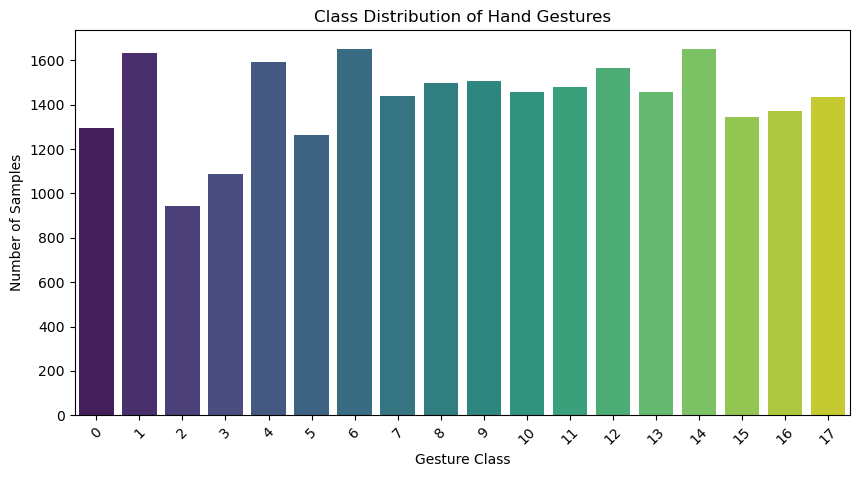

In [64]:
# Check Class Distribution
class_counts = normalized_df['label'].value_counts()
print(class_counts)

# Plot Class Distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xlabel("Gesture Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution of Hand Gestures")
plt.xticks(rotation=45)
plt.show()

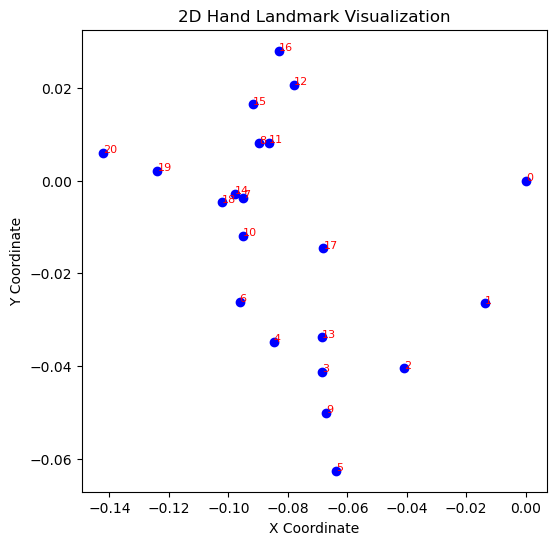

In [40]:
# Select one sample to visualize
sample = normalized_df.iloc[0, :-1].values.reshape(-1, 2) 

# Scatter Plot
plt.figure(figsize=(6, 6))
plt.scatter(sample[:, 0], sample[:, 1], c="blue", marker="o")  # X vs Y

for i, txt in enumerate(range(len(sample))):
    plt.annotate(txt, (sample[i, 0], sample[i, 1]), fontsize=8, color="red")

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("2D Hand Landmark Visualization")
plt.show()


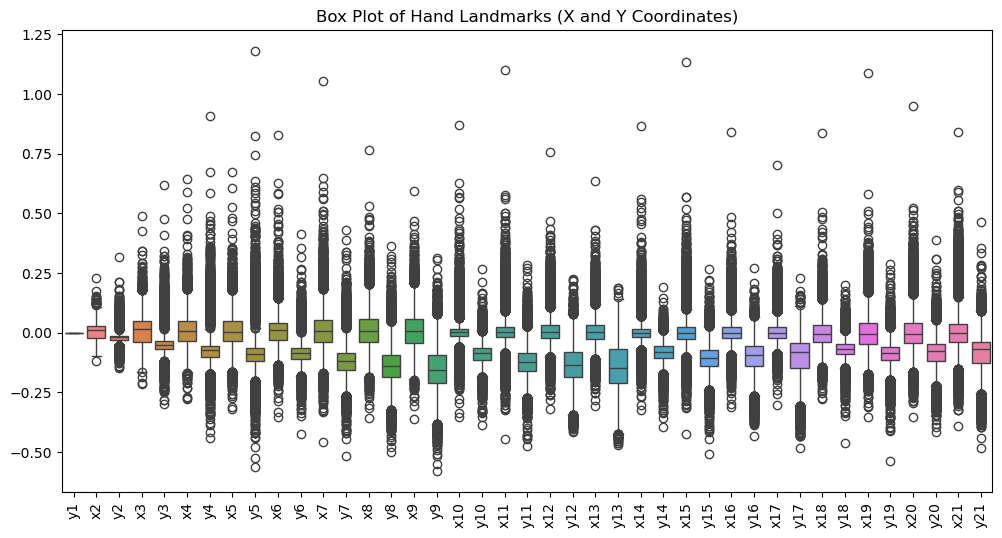

In [32]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=normalized_df.iloc[:, 1:-1])  # Skip first and last columns
plt.xticks(rotation=90)
plt.title("Box Plot of Hand Landmarks (X and Y Coordinates)")
plt.show()

Box Plot of Hand Landmarks (X and Y Coordinates). Outlier removal is unnecessary as the outliers are relatively sparse and may represent meaningful hand variations rather than noise.

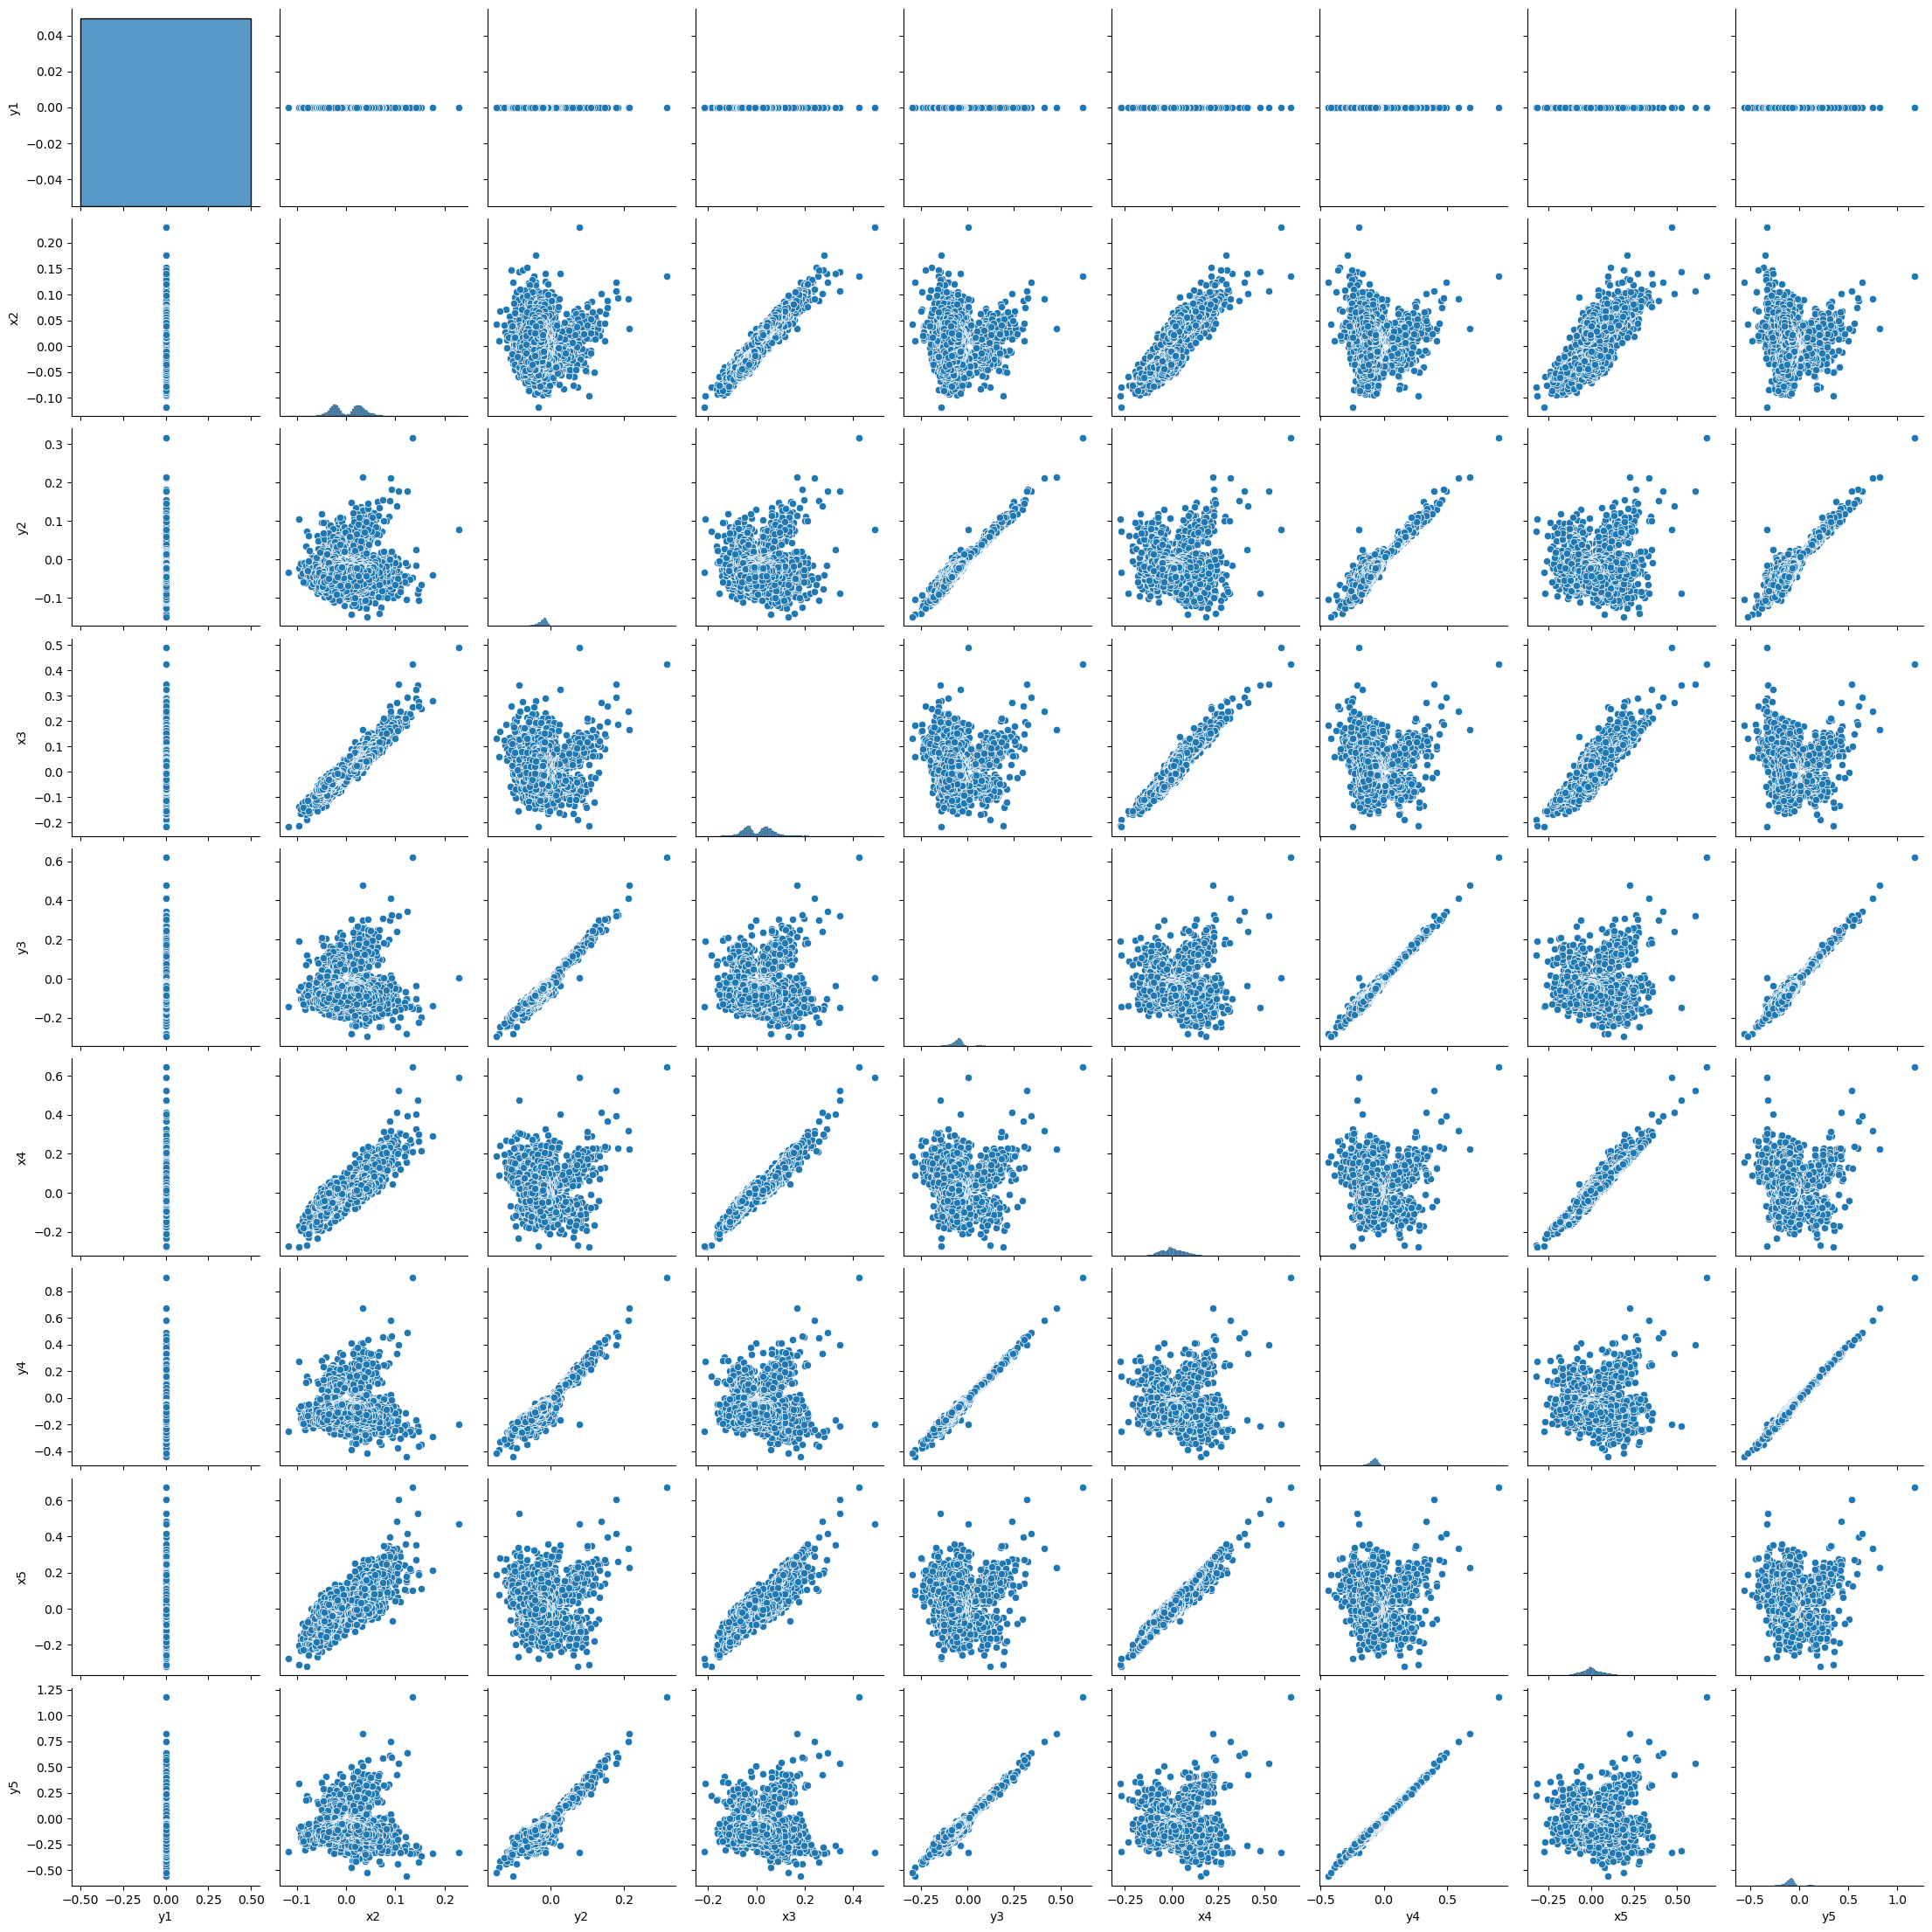

In [44]:
sns.pairplot(normalized_df.iloc[:, 1:10])  # Select a few columns to avoid clutter
plt.show()

       y1        x2        y2        x3        y3        x4        y4  \
y1    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
x2    NaN  1.000000 -0.010351  0.968800 -0.054194  0.862102 -0.077326   
y2    NaN -0.010351  1.000000 -0.022632  0.972493 -0.027500  0.935596   
x3    NaN  0.968800 -0.022632  1.000000 -0.060580  0.951786 -0.081288   
y3    NaN -0.054194  0.972493 -0.060580  1.000000 -0.052928  0.988847   
x4    NaN  0.862102 -0.027500  0.951786 -0.052928  1.000000 -0.067499   
y4    NaN -0.077326  0.935596 -0.081288  0.988847 -0.067499  1.000000   
x5    NaN  0.724581 -0.020986  0.842656 -0.034400  0.963127 -0.042315   
y5    NaN -0.085721  0.913882 -0.088588  0.971843 -0.073311  0.993452   
x6    NaN  0.748703  0.000810  0.840430 -0.021569  0.815451 -0.035923   
y6    NaN -0.168815  0.703795 -0.169126  0.818757 -0.147505  0.844899   
x7    NaN  0.721660 -0.036381  0.826114 -0.057365  0.816384 -0.070048   
y7    NaN -0.141674  0.574081 -0.130538  0.705427 -

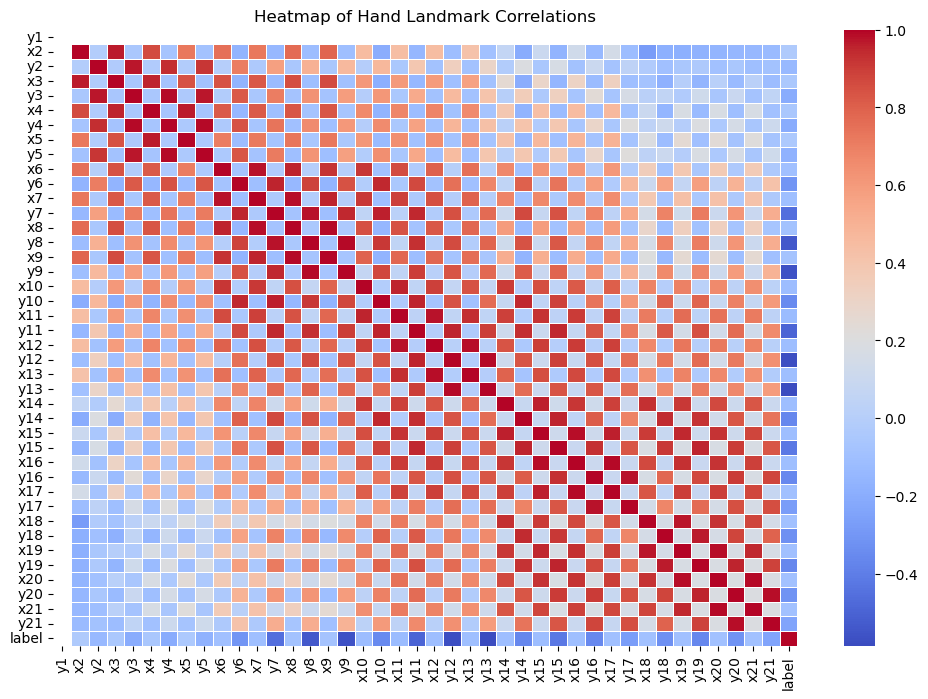

In [43]:
# Compute correlation matrix (excluding first column if needed)
corr_matrix = normalized_df.iloc[:, 1:].corr()  

# Display correlation values
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap of Hand Landmark Correlations")
plt.show()


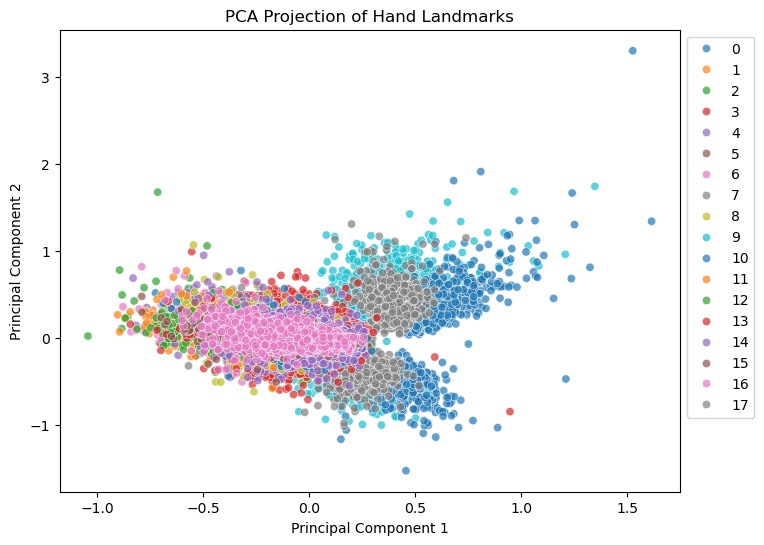

In [34]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(normalized_df.iloc[:, :-1])  # Exclude label column

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=normalized_df['label'], palette="tab10", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Hand Landmarks")
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()


Given overlapping gestures, a more sophisticated classifier (e.g., deep learning or ensemble methods) may be required to improve accuracy.

# Model implementation 

In [65]:
# Separate features (X) and label (y)
X = normalized_df.drop(columns=["label"])  # Features
y = normalized_df["label"]  # Target


In [66]:
# Split the dataset into training,val,test
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [67]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



# Initialize individual models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", use_label_encoder=False),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Initialize the ensemble model (Voting Classifier)
ensemble_model = VotingClassifier(estimators=[
    ('rf', models['Random Forest']),
    ('svm', models['SVM']),
    ('xgb', models['XGBoost']),
    ('lr', models['Logistic Regression']),
    ('dt', models['Decision Tree'])
], voting='hard')  # 'hard' voting for classification (majority rule)

# Add ensemble to models dictionary for easier handling
models['Ensemble'] = ensemble_model

# Set up K-Fold Cross Validation
kf = KFold(n_splits=7, shuffle=True, random_state=42)

# Dictionary to store results
results = {}

# Perform Cross-Validation for each model
for name, model in models.items():
    print(f"Training and evaluating {name}...")

    # Cross-validation score (accuracy)
    scores = cross_val_score(model, X_train_temp, y_train_temp, cv=kf, scoring='accuracy')
    mean_accuracy = np.mean(scores)
    std_dev = np.std(scores)

    # Store the results
    results[name] = {
        'mean_accuracy': mean_accuracy,
        'std_dev': std_dev
    }

    # Train the model on the full training data
    model.fit(X_train_temp, y_train_temp)
    
    # Predictions on the training set
    y_pred_train = model.predict(X_train_temp)
    
    # Compute evaluation metrics for training data
    accuracy = accuracy_score(y_train_temp, y_pred_train)
    precision = precision_score(y_train_temp, y_pred_train, average='macro')
    recall = recall_score(y_train_temp, y_pred_train, average='macro')
    f1 = f1_score(y_train_temp, y_pred_train, average='macro')

    # Add metrics to results
    results[name].update({
        'train_accuracy': accuracy,
        'train_precision': precision,
        'train_recall': recall,
        'train_f1': f1
    })

    print(f"{name} (Train) - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    
# Evaluate models on the validation set
for name, model in models.items():
    y_pred_val = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    val_precision = precision_score(y_val, y_pred_val, average='macro')
    val_recall = recall_score(y_val, y_pred_val, average='macro')
    val_f1 = f1_score(y_val, y_pred_val, average='macro')
    
    results[name].update({
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1
    })
    
    print(f"{name} Validation - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-score: {val_f1:.4f}")

# Final evaluation on the test set
for name, model in models.items():
    y_pred_test = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test, average='macro')
    test_recall = recall_score(y_test, y_pred_test, average='macro')
    test_f1 = f1_score(y_test, y_pred_test, average='macro')
    
    results[name].update({
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1
    })
    
    print(f"{name} Test - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}")

# Conclusion: Summarizing the best model
best_model_name = max(results, key=lambda k: results[k]['test_accuracy'])
best_model_results = results[best_model_name]

print("\nSummary of Results:")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"  Training Accuracy: {metrics['train_accuracy']:.4f}")
    print(f"  Validation Accuracy: {metrics['val_accuracy']:.4f}")
    print(f"  Test Accuracy: {metrics['test_accuracy']:.4f}")
    print(f"  Precision: {metrics['test_precision']:.4f}")
    print(f"  Recall: {metrics['test_recall']:.4f}")
    print(f"  F1-score: {metrics['test_f1']:.4f}")

print(f"\nBest Performing Model: {best_model_name}")
print(f"Test Accuracy: {best_model_results['test_accuracy']:.4f}")
print(f"Test Precision: {best_model_results['test_precision']:.4f}")
print(f"Test Recall: {best_model_results['test_recall']:.4f}")
print(f"Test F1-score: {best_model_results['test_f1']:.4f}")


Training and evaluating Random Forest...
Random Forest (Train) - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Training and evaluating SVM...
SVM (Train) - Accuracy: 0.7119, Precision: 0.7687, Recall: 0.7119, F1-score: 0.6992
Training and evaluating XGBoost...


c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:34:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:34:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:34:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:34:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

XGBoost (Train) - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Training and evaluating Logistic Regression...
Logistic Regression (Train) - Accuracy: 0.7127, Precision: 0.7363, Recall: 0.7173, F1-score: 0.7146
Training and evaluating Decision Tree...
Decision Tree (Train) - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Training and evaluating Ensemble...


c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:35:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:36:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:36:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:37:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

Ensemble (Train) - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Random Forest Validation - Accuracy: 0.9571, Precision: 0.9582, Recall: 0.9566, F1-score: 0.9572
SVM Validation - Accuracy: 0.7024, Precision: 0.7443, Recall: 0.6931, F1-score: 0.6811
XGBoost Validation - Accuracy: 0.9665, Precision: 0.9668, Recall: 0.9661, F1-score: 0.9664
Logistic Regression Validation - Accuracy: 0.7055, Precision: 0.7223, Recall: 0.7000, F1-score: 0.6979
Decision Tree Validation - Accuracy: 0.8968, Precision: 0.8959, Recall: 0.8958, F1-score: 0.8956
Ensemble Validation - Accuracy: 0.9420, Precision: 0.9450, Recall: 0.9414, F1-score: 0.9422
Random Forest Test - Accuracy: 0.9599, Precision: 0.9605, Recall: 0.9602, F1-score: 0.9601
SVM Test - Accuracy: 0.7153, Precision: 0.7772, Recall: 0.7128, F1-score: 0.7005
XGBoost Test - Accuracy: 0.9704, Precision: 0.9702, Recall: 0.9701, F1-score: 0.9700
Logistic Regression Test - Accuracy: 0.7009, Precision: 0.7239, Recall: 0.7050, F1-scor

the output shows that the model might be overfitting so optimizations are required

# Optimization

### Adding new features and hyperparameter tuning may improve the model and prevent overfitting.

1. Adding new features

In [68]:
def calculate_finger_tip_distances(df):
    """
    Calculate distances between finger tips and create new features
    Args:
        df: DataFrame with columns x1,y1,x2,y2,...,x20,y20 (indices 1-20)
    Returns:
        DataFrame with new distance features added
    """
    df = df.copy()
    
    # Define indices according to YOUR dataset (1-20)
    TIP_INDICES = {
        'thumb': 5,   # Changed from original 4 to match your data
        'index': 9,   # Changed from 8
        'middle': 13, # Changed from 12
        'ring': 17,   # Changed from 16
        'pinky': 21   # Changed from 20
    }
    
    FINGER_BASES = {
        'thumb': 2,   # Base of thumb
        'index': 6,   # Knuckle of index
        'middle': 10,  # Knuckle of middle
        'ring': 14,   # Knuckle of ring
        'pinky': 18   # Knuckle of pinky
    }

    # 1. Calculate all pairwise tip distances
    tips = list(TIP_INDICES.values())
    for i, tip1 in enumerate(tips[:-1]):
        for tip2 in tips[i+1:]:
            # Calculate Euclidean distance
            dist = np.sqrt(
                (df[f'x{tip1}'] - df[f'x{tip2}'])**2 + 
                (df[f'y{tip1}'] - df[f'y{tip2}'])**2
            )
            
            # Name the feature
            name1 = [k for k,v in TIP_INDICES.items() if v == tip1][0]
            name2 = [k for k,v in TIP_INDICES.items() if v == tip2][0]
            df[f'dist_{name1}_{name2}'] = dist

    # 2. Thumb-to-other distances
    thumb_x, thumb_y = df['x5'], df['y5']  # Using your thumb tip index
    for finger in ['index', 'middle', 'ring', 'pinky']:
        tip = TIP_INDICES[finger]
        df[f'dist_thumb_{finger}'] = np.sqrt(
            (thumb_x - df[f'x{tip}'])**2 + 
            (thumb_y - df[f'y{tip}'])**2
        )

    # 3. Finger lengths (base to tip)
    for finger, base in FINGER_BASES.items():
        tip = TIP_INDICES[finger]
        df[f'len_{finger}'] = np.sqrt(
            (df[f'x{base}'] - df[f'x{tip}'])**2 + 
            (df[f'y{base}'] - df[f'y{tip}'])**2
        )
    
    return df

In [69]:
df_features = normalized_df.drop(columns=['label'])

In [70]:
# Add features
enhanced_df = calculate_finger_tip_distances(df_features)
final_df = pd.concat([enhanced_df,normalized_df["label"] ], axis=1)
final_df

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,...,dist_index_pinky,dist_middle_ring,dist_middle_pinky,dist_ring_pinky,len_thumb,len_index,len_middle,len_ring,len_pinky,label
0,0.0,0.0,-0.013660,-0.026516,-0.041057,-0.040539,-0.068360,-0.041223,-0.084764,-0.034738,...,0.052451,0.008825,0.065725,0.063120,0.071578,0.075218,0.071584,0.063428,0.076931,9
1,0.0,0.0,-0.003891,-0.047718,0.018350,-0.094155,0.033518,-0.128722,0.030323,-0.160255,...,0.121983,0.023491,0.110881,0.093991,0.117622,0.037833,0.029884,0.019994,0.098733,9
2,0.0,0.0,0.025447,-0.061868,0.064421,-0.120770,0.091356,-0.169126,0.089240,-0.210171,...,0.162812,0.034932,0.148693,0.134482,0.161442,0.065713,0.055562,0.045191,0.143387,9
3,0.0,0.0,-0.001326,-0.030937,0.004650,-0.060263,0.007587,-0.083251,0.005014,-0.102569,...,0.081606,0.016056,0.065803,0.054993,0.071912,0.014427,0.012597,0.009052,0.057454,9
4,0.0,0.0,-0.001198,-0.060172,0.013919,-0.134128,0.016406,-0.187936,-0.002427,-0.224149,...,0.143516,0.028938,0.129711,0.120876,0.163981,0.046969,0.038009,0.027080,0.127879,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25670,0.0,0.0,0.025562,-0.043183,0.021827,-0.085481,-0.003849,-0.105901,-0.029400,-0.111233,...,0.142286,0.124428,0.144034,0.021630,0.087474,0.109473,0.118779,0.004358,0.013855,16
25671,0.0,0.0,-0.034672,-0.049861,-0.030986,-0.097018,-0.001874,-0.121699,0.023168,-0.126529,...,0.184290,0.163935,0.186819,0.028886,0.096039,0.139716,0.153801,0.006897,0.016183,16
25672,0.0,0.0,0.039972,-0.042022,0.042354,-0.091236,0.022741,-0.127632,0.001470,-0.148305,...,0.205431,0.183623,0.209682,0.030854,0.113042,0.147030,0.156739,0.018363,0.029005,16
25673,0.0,0.0,-0.018347,-0.044186,-0.006131,-0.086211,0.023301,-0.105944,0.049186,-0.107495,...,0.165453,0.144493,0.169356,0.026351,0.092567,0.114508,0.131160,0.018240,0.006629,16


In [71]:
# Separate features (X) and label (y)
X = final_df.drop(columns=["label"])  # Features
y = final_df["label"]  # Target
# Split the dataset into training,val,test
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [91]:
!pip install --upgrade mlflow


In [97]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import mlflow.sklearn

# 1) Use MLflow's default local ./mlruns folder
#    (no need to set_tracking_uri or fiddle with env vars)
mlflow.set_experiment("HandGesture_Classification")

# 2) Load / preprocess your data into X, y here:
#    e.g. df = pd.read_csv(...); X = df.drop("label", axis=1); y = df["label"]
#    (Make sure you've already applied your 4-label renaming and encoding.)
# X, y = ...

# 3) Split into train/val/test (70/15/15 roughly)
X_train_temp, X_test,  y_train_temp, y_test  = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y)
X_train_temp, X_val,   y_train_temp, y_val   = train_test_split(
    X_train_temp, y_train_temp, test_size=0.1765, random_state=42, stratify=y_train_temp)

# 4) Define your models
models = {
    "Random Forest":       RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM":                 SVC(kernel='linear', probability=True, random_state=42),
    "XGBoost":             XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree":       DecisionTreeClassifier(random_state=42),
}
ensemble = VotingClassifier(
    estimators=[(k, m) for k, m in models.items()],
    voting="hard"
)
models["Ensemble"] = ensemble

# 5) Prepare K-Fold for CV
kf = KFold(n_splits=7, shuffle=True, random_state=42)

# 6) Loop through models, log each run
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        # Cross-validation
        cv_scores = cross_val_score(model, X_train_temp, y_train_temp, cv=kf, scoring="accuracy")
        mlflow.log_metric("cv_mean_accuracy", np.mean(cv_scores))
        mlflow.log_metric("cv_std_dev",     np.std(cv_scores))

        # Fit on full training set
        model.fit(X_train_temp, y_train_temp)

        # Helper to compute and log metrics
        def eval_and_log(split_name, X_split, y_true):
            y_pred = model.predict(X_split)
            metrics = {
                f"{split_name}_accuracy":  accuracy_score(y_true, y_pred),
                f"{split_name}_precision": precision_score(y_true, y_pred, average="macro"),
                f"{split_name}_recall":    recall_score(y_true, y_pred, average="macro"),
                f"{split_name}_f1":        f1_score(y_true, y_pred, average="macro"),
            }
            for k, v in metrics.items():
                mlflow.log_metric(k, v)
            return metrics

        train_metrics = eval_and_log("train", X_train_temp, y_train_temp)
        val_metrics   = eval_and_log("val",   X_val,        y_val)
        test_metrics  = eval_and_log("test",  X_test,       y_test)

        # Log model artifact
        mlflow.sklearn.log_model(model, artifact_path="model")

        # Print summary
        print(f"\n=== {name} ===")
        for split, m in [("Train", train_metrics), ("Val", val_metrics), ("Test", test_metrics)]:
            print(f"{split}: acc={m[f'{split.lower()}_accuracy']:.4f}  "
                  f"prec={m[f'{split.lower()}_precision']:.4f}  "
                  f"rec={m[f'{split.lower()}_recall']:.4f}  "
                  f"f1={m[f'{split.lower()}_f1']:.4f}")


2025/05/28 17:47:29 INFO mlflow.tracking.fluent: Experiment with name 'HandGesture_Classification' does not exist. Creating a new experiment.
2025/05/28 17:49:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Random Forest ===
Train: acc=1.0000  prec=1.0000  rec=1.0000  f1=1.0000
Val: acc=0.9720  prec=0.9725  rec=0.9722  f1=0.9722
Test: acc=0.9725  prec=0.9726  rec=0.9726  f1=0.9725
🏃 View run Random Forest at: http://localhost:5000/#/experiments/1/runs/e03c4423395e4ae58b0eb8537e580a68
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/05/28 17:51:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== SVM ===
Train: acc=0.9570  prec=0.9568  rec=0.9557  f1=0.9556
Val: acc=0.9564  prec=0.9569  rec=0.9557  f1=0.9558
Test: acc=0.9546  prec=0.9538  rec=0.9533  f1=0.9532
🏃 View run SVM at: http://localhost:5000/#/experiments/1/runs/ef7857e6c8f84267b48b6bfcdf039c5a
🧪 View experiment at: http://localhost:5000/#/experiments/1


c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:51:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:52:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:52:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:52:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr


=== XGBoost ===
Train: acc=1.0000  prec=1.0000  rec=1.0000  f1=1.0000
Val: acc=0.9772  prec=0.9772  rec=0.9771  f1=0.9771
Test: acc=0.9759  prec=0.9759  rec=0.9760  f1=0.9759
🏃 View run XGBoost at: http://localhost:5000/#/experiments/1/runs/1097c4ef4df44198b8f5412d86d5280d
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/05/28 17:52:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Logistic Regression ===
Train: acc=0.9474  prec=0.9472  rec=0.9458  f1=0.9458
Val: acc=0.9418  prec=0.9428  rec=0.9410  f1=0.9410
Test: acc=0.9431  prec=0.9427  rec=0.9416  f1=0.9417
🏃 View run Logistic Regression at: http://localhost:5000/#/experiments/1/runs/4d82e4e9a1254f0ca108108060010115
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/05/28 17:53:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Decision Tree ===
Train: acc=1.0000  prec=1.0000  rec=1.0000  f1=1.0000
Val: acc=0.9330  prec=0.9330  rec=0.9331  f1=0.9328
Test: acc=0.9335  prec=0.9342  rec=0.9336  f1=0.9338
🏃 View run Decision Tree at: http://localhost:5000/#/experiments/1/runs/0e080c340a794dc99e5ba60e74425af4
🧪 View experiment at: http://localhost:5000/#/experiments/1


c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:53:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:54:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:54:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ayman\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:55:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr


=== Ensemble ===
Train: acc=1.0000  prec=1.0000  rec=1.0000  f1=1.0000
Val: acc=0.9720  prec=0.9723  rec=0.9719  f1=0.9721
Test: acc=0.9730  prec=0.9732  rec=0.9730  f1=0.9730
🏃 View run Ensemble at: http://localhost:5000/#/experiments/1/runs/2b783fa4e76040c08d1d45bc6156c7f9
🧪 View experiment at: http://localhost:5000/#/experiments/1


2. hyperparameter tuning

In [98]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Split the dataset into training, validation, and test sets
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the XGBoost model with regularization
xgb_model = XGBClassifier(eval_metric="logloss", random_state=42)

# Define hyperparameter grid for tuning (with additional values to prevent overfitting)
param_grid = {
    'colsample_bytree': [0.7],
    'gamma': [1],
    'learning_rate': [0.05],
    'max_depth': [4],
    'min_child_weight': [5],
    'n_estimators': [200],
    'subsample': [0.8],
    'reg_alpha': [0.2],
    'reg_lambda': [0.8]     
}

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')

# Fit the GridSearchCV on the training data
grid_search.fit(X_train_temp, y_train_temp)

# Print all results per run
print("\n=== Grid Search Results ===")
for mean_score, params in zip(grid_search.cv_results_["mean_test_score"], grid_search.cv_results_["params"]):
    print(f"Params: {params}, Mean Accuracy: {mean_score:.4f}")

# Get the best hyperparameters
print(f"\nBest Parameters: {grid_search.best_params_}")

# Train the best model from grid search
best_model = grid_search.best_estimator_

# Function to calculate precision and F1 for multiclass (weighted average)
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Weighted average for multiclass
    f1 = f1_score(y_true, y_pred, average='weighted')  # Weighted average for multiclass
    return accuracy, precision, f1

# Evaluate on training set
train_pred = best_model.predict(X_train_temp)
train_accuracy, train_precision, train_f1 = calculate_metrics(y_train_temp, train_pred)

print("\nTraining Set Evaluation:")
print(f"Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, F1-Score: {train_f1:.4f}")

# Evaluate on validation set
val_pred = best_model.predict(X_val)
val_accuracy, val_precision, val_f1 = calculate_metrics(y_val, val_pred)

print("\nValidation Set Evaluation:")
print(f"Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, F1-Score: {val_f1:.4f}")

# Final evaluation on test set
test_pred = best_model.predict(X_test)
test_accuracy, test_precision, test_f1 = calculate_metrics(y_test, test_pred)

print("\nTest Set Evaluation:")
print(f"Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, F1-Score: {test_f1:.4f}")

# K-Fold Cross-Validation (with the best model)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train_temp, y_train_temp, cv=kf, scoring='accuracy')

print(f"\nXGBoost K-Fold Cross-Validation Mean Accuracy: {np.mean(cv_scores):.4f}, Std Dev = {np.std(cv_scores):.4f}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits

=== Grid Search Results ===
Params: {'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.2, 'reg_lambda': 0.8, 'subsample': 0.8}, Mean Accuracy: 0.9751

Best Parameters: {'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.2, 'reg_lambda': 0.8, 'subsample': 0.8}

Training Set Evaluation:
Accuracy: 0.9920, Precision: 0.9920, F1-Score: 0.9920

Validation Set Evaluation:
Accuracy: 0.9723, Precision: 0.9726, F1-Score: 0.9724

Test Set Evaluation:
Accuracy: 0.9727, Precision: 0.9729, F1-Score: 0.9727

XGBoost K-Fold Cross-Validation Mean Accuracy: 0.9752, Std Dev = 0.0007


In [99]:
import json

# Save the label mapping
with open("label_map.json", "w") as f:
    json.dump(gesture_map, f)

# Log to MLflow
mlflow.log_artifact("label_map.json")


In [100]:
# Save the best model to a file
model_filename = 'best_xgboost.joblib'
joblib.dump(best_model, model_filename)
print(f"\nModel saved to {model_filename}")


Model saved to best_xgboost.joblib


In [101]:
loaded_model = joblib.load('best_xgboost.joblib')
# Make predictions using the loaded model
y_pred = loaded_model.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred)

print(f"Final Test Accuracy of the Loaded Model: {final_accuracy:.4f}")


Final Test Accuracy of the Loaded Model: 0.9727
